In [0]:
!

In [0]:
import dlib
import cv2
import numpy as np
import matplotlib.pyplot as plt

import matplotlib
%matplotlib inline
# from renderFace import renderFace

In [0]:
# !pip freeze > requirements.txt


In [0]:
# from google.colab import drive
# drive.mount('/content/drive/')
# main_path = '/content/drive/My Drive/video_files/'

In [0]:
main_path = '/content/'

# faceBlendCommon

In [0]:
import cv2
import dlib
import numpy as np
import math

# Returns 8 points on the boundary of a rectangle
def getEightBoundaryPoints(h, w):
  boundaryPts = []
  boundaryPts.append((0,0))
  boundaryPts.append((w/2, 0))
  boundaryPts.append((w-1,0))
  boundaryPts.append((w-1, h/2))
  boundaryPts.append((w-1, h-1))
  boundaryPts.append((w/2, h-1))
  boundaryPts.append((0, h-1))
  boundaryPts.append((0, h/2))
  return np.array(boundaryPts, dtype=np.float)


# Constrains points to be inside boundary
def constrainPoint(p, w, h):
  p = (min(max(p[0], 0), w - 1), min(max(p[1], 0), h - 1))
  return p

# convert Dlib shape detector object to list of tuples
def dlibLandmarksToPoints(shape):
  points = []
  for p in shape.parts():
    pt = (p.x, p.y)
    points.append(pt)
  return points

# Compute similarity transform given two sets of two points.
# OpenCV requires 3 pairs of corresponding points.
# We are faking the third one.
def similarityTransform(inPoints, outPoints):
  s60 = math.sin(60*math.pi/180)
  c60 = math.cos(60*math.pi/180)

  inPts = np.copy(inPoints).tolist()
  outPts = np.copy(outPoints).tolist()

  # The third point is calculated so that the three points make an equilateral triangle
  xin = c60*(inPts[0][0] - inPts[1][0]) - s60*(inPts[0][1] - inPts[1][1]) + inPts[1][0]
  yin = s60*(inPts[0][0] - inPts[1][0]) + c60*(inPts[0][1] - inPts[1][1]) + inPts[1][1]

  inPts.append([np.int(xin), np.int(yin)])

  xout = c60*(outPts[0][0] - outPts[1][0]) - s60*(outPts[0][1] - outPts[1][1]) + outPts[1][0]
  yout = s60*(outPts[0][0] - outPts[1][0]) + c60*(outPts[0][1] - outPts[1][1]) + outPts[1][1]

  outPts.append([np.int(xout), np.int(yout)])

  # Now we can use estimateRigidTransform for calculating the similarity transform.
  tform = cv2.estimateAffinePartial2D(np.array([inPts]), np.array([outPts]))
  return tform[0]
    
# Normalizes a facial image to a standard size given by outSize.
# Normalization is done based on Dlib's landmark points passed as pointsIn
# After normalization, left corner of the left eye is at (0.3 * w, h/3 )
# and right corner of the right eye is at ( 0.7 * w, h / 3) where w and h
# are the width and height of outSize.
def normalizeImagesAndLandmarks(outSize, imIn, pointsIn):
  h, w = outSize
#   print(f"(HxW)={outSize} not matching with video frames shape={imIn.shape}")
  # Corners of the eye in input image
  if len(pointsIn) == 68:
    eyecornerSrc = [pointsIn[36], pointsIn[45]]
  elif len(pointsIn) == 5:
    eyecornerSrc = [pointsIn[2], pointsIn[0]]
  else:
    print(f"(H x W)={outSize} not matching with video frames shape={imIn.shape}")

  # Corners of the eye in normalized image
  eyecornerDst = [(np.int(0.3 * w), np.int(h/3)),
                  (np.int(0.7 * w), np.int(h/3))]

  # Calculate similarity transform
  tform = similarityTransform(eyecornerSrc, eyecornerDst)
  imOut = np.zeros(imIn.shape, dtype=imIn.dtype)

  # Apply similarity transform to input image
  imOut = cv2.warpAffine(imIn, tform, (w, h))

  # reshape pointsIn from numLandmarks x 2 to numLandmarks x 1 x 2
  points2 = np.reshape(pointsIn, (pointsIn.shape[0], 1, pointsIn.shape[1]))

  # Apply similarity transform to landmarks
  pointsOut = cv2.transform(points2, tform)

  # reshape pointsOut to numLandmarks x 2
  pointsOut = np.reshape(pointsOut, (pointsIn.shape[0], pointsIn.shape[1]))

  return imOut, pointsOut

# find the point closest to an array of points
# pointsArray is a Nx2 and point is 1x2 ndarray
def findIndex(pointsArray, point):
  dist = np.linalg.norm(pointsArray-point, axis=1)
  minIndex = np.argmin(dist)
  return minIndex


# Check if a point is inside a rectangle
def rectContains(rect, point):
  if point[0] < rect[0]:
    return False
  elif point[1] < rect[1]:
    return False
  elif point[0] > rect[2]:
    return False
  elif point[1] > rect[3]:
    return False
  return True


# Calculate Delaunay triangles for set of points
# Returns the vector of indices of 3 points for each triangle
def calculateDelaunayTriangles(rect, points):

  # Create an instance of Subdiv2D
  subdiv = cv2.Subdiv2D(rect)

  # Insert points into subdiv
  for p in points:
    subdiv.insert((p[0], p[1]))

  # Get Delaunay triangulation
  triangleList = subdiv.getTriangleList()

  # Find the indices of triangles in the points array
  delaunayTri = []

  for t in triangleList:
    # The triangle returned by getTriangleList is
    # a list of 6 coordinates of the 3 points in
    # x1, y1, x2, y2, x3, y3 format.
    # Store triangle as a list of three points
    pt = []
    pt.append((t[0], t[1]))
    pt.append((t[2], t[3]))
    pt.append((t[4], t[5]))

    pt1 = (t[0], t[1])
    pt2 = (t[2], t[3])
    pt3 = (t[4], t[5])

    if rectContains(rect, pt1) and rectContains(rect, pt2) and rectContains(rect, pt3):
      # Variable to store a triangle as indices from list of points
      ind = []
      # Find the index of each vertex in the points list
      for j in range(0, 3):
        for k in range(0, len(points)):
          if(abs(pt[j][0] - points[k][0]) < 1.0 and abs(pt[j][1] - points[k][1]) < 1.0):
            ind.append(k)
        # Store triangulation as a list of indices
      if len(ind) == 3:
        delaunayTri.append((ind[0], ind[1], ind[2]))

  return delaunayTri

# Apply affine transform calculated using srcTri and dstTri to src and
# output an image of size.
def applyAffineTransform(src, srcTri, dstTri, size):

  # Given a pair of triangles, find the affine transform.
  warpMat = cv2.getAffineTransform(np.float32(srcTri), np.float32(dstTri))

  # Apply the Affine Transform just found to the src image
  dst = cv2.warpAffine(src, warpMat, (size[0], size[1]), None,
             flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT_101)

  return dst

# Warps and alpha blends triangular regions from img1 and img2 to img
def warpTriangle(img1, img2, t1, t2):
  # Find bounding rectangle for each triangle
  r1 = cv2.boundingRect(np.float32([t1]))
  r2 = cv2.boundingRect(np.float32([t2]))

  # Offset points by left top corner of the respective rectangles
  t1Rect = []
  t2Rect = []
  t2RectInt = []

  for i in range(0, 3):
    t1Rect.append(((t1[i][0] - r1[0]), (t1[i][1] - r1[1])))
    t2Rect.append(((t2[i][0] - r2[0]), (t2[i][1] - r2[1])))
    t2RectInt.append(((t2[i][0] - r2[0]), (t2[i][1] - r2[1])))

  # Get mask by filling triangle
  mask = np.zeros((r2[3], r2[2], 3), dtype=np.float32)
  cv2.fillConvexPoly(mask, np.int32(t2RectInt), (1.0, 1.0, 1.0), 16, 0)

  # Apply warpImage to small rectangular patches
  img1Rect = img1[r1[1]:r1[1] + r1[3], r1[0]:r1[0] + r1[2]]

  size = (r2[2], r2[3])

  img2Rect = applyAffineTransform(img1Rect, t1Rect, t2Rect, size)

  img2Rect = img2Rect * mask

  # Copy triangular region of the rectangular patch to the output image
  img2[r2[1]:r2[1]+r2[3], r2[0]:r2[0]+r2[2]] = img2[r2[1]:r2[1]+r2[3], r2[0]:r2[0]+r2[2]] * ((1.0, 1.0, 1.0) - mask)
  img2[r2[1]:r2[1]+r2[3], r2[0]:r2[0]+r2[2]] = img2[r2[1]:r2[1]+r2[3], r2[0]:r2[0]+r2[2]] + img2Rect

# detect facial landmarks in image
def getLandmarks(faceDetector, landmarkDetector, im, FACE_DOWNSAMPLE_RATIO = 1):
  points = []
  imSmall = cv2.resize(im,None,
                       fx=1.0/FACE_DOWNSAMPLE_RATIO,
                       fy=1.0/FACE_DOWNSAMPLE_RATIO,
                       interpolation = cv2.INTER_LINEAR)

  faceRects = faceDetector(imSmall, 0)

  if len(faceRects) > 0:
    maxArea = 0
    maxRect = None
    # TODO: test on images with multiple faces
    for face in faceRects:
      if face.area() > maxArea:
        maxArea = face.area()
        maxRect = [face.left(),
                   face.top(),
                   face.right(),
                   face.bottom()
                  ]

    rect = dlib.rectangle(*maxRect)
    scaledRect = dlib.rectangle(int(rect.left()*FACE_DOWNSAMPLE_RATIO),
                             int(rect.top()*FACE_DOWNSAMPLE_RATIO),
                             int(rect.right()*FACE_DOWNSAMPLE_RATIO),
                             int(rect.bottom()*FACE_DOWNSAMPLE_RATIO))

    landmarks = landmarkDetector(im, scaledRect)
    points = dlibLandmarksToPoints(landmarks)
  return points

# Warps an image in a piecewise affine manner.
# The warp is defined by the movement of landmark points specified by pointsIn
# to a new location specified by pointsOut. The triangulation beween points is specified
# by their indices in delaunayTri.
def warpImage(imIn, pointsIn, pointsOut, delaunayTri):
  h, w, ch = imIn.shape
  # Output image
  imOut = np.zeros(imIn.shape, dtype=imIn.dtype)

  # Warp each input triangle to output triangle.
  # The triangulation is specified by delaunayTri
  for j in range(0, len(delaunayTri)):
    # Input and output points corresponding to jth triangle
    tin = []
    tout = []

    for k in range(0, 3):
      # Extract a vertex of input triangle
      pIn = pointsIn[delaunayTri[j][k]]
      # Make sure the vertex is inside the image.
      pIn = constrainPoint(pIn, w, h)

      # Extract a vertex of the output triangle
      pOut = pointsOut[delaunayTri[j][k]]
      # Make sure the vertex is inside the image.
      pOut = constrainPoint(pOut, w, h)

      # Push the input vertex into input triangle
      tin.append(pIn)
      # Push the output vertex into output triangle
      tout.append(pOut)

    # Warp pixels inside input triangle to output triangle.
    warpTriangle(imIn, imOut, tin, tout)
  return imOut


# renderFace

In [0]:
import cv2
import numpy as np


def drawPolyline(im, landmarks, start, end, isClosed=False):
  points = []
  for i in range(start, end+1):
    point = [landmarks.part(i).x, landmarks.part(i).y]
    points.append(point)

  points = np.array(points, dtype=np.int32)
  cv2.polylines(im, [points], isClosed, (255, 200, 0), thickness=2, lineType=cv2.LINE_8)

# Use this function for 70-points facial landmark detector model
def renderFace(im, landmarks):
    assert(landmarks.num_parts == 68)
    drawPolyline(im, landmarks, 0, 16)           # Jaw line
    drawPolyline(im, landmarks, 17, 21)          # Left eyebrow
    drawPolyline(im, landmarks, 22, 26)          # Right eyebrow
    drawPolyline(im, landmarks, 27, 30)          # Nose bridge
    drawPolyline(im, landmarks, 30, 35, True)    # Lower nose
    drawPolyline(im, landmarks, 36, 41, True)    # Left eye
    drawPolyline(im, landmarks, 42, 47, True)    # Right Eye
    drawPolyline(im, landmarks, 48, 59, True)    # Outer lip
    drawPolyline(im, landmarks, 60, 67, True)    # Inner lip

# Use this function for any model other than
# 70 points facial_landmark detector model
def renderFace2(im, landmarks, color=(0, 255, 0), radius=3):
  for p in landmarks.parts():
    cv2.circle(im, (p.x, p.y), radius, color, -1)

# normalizeImagesAndLandmarks

In [0]:
def normalizeImagesAndLandmarks(outSize, imIn, pointsIn):
  h, w = outSize

  # Corners of the eye in input image
  if len(pointsIn) == 68:
    eyecornerSrc = [pointsIn[36], pointsIn[45]]
  elif len(pointsIn) == 5:
    eyecornerSrc = [pointsIn[2], pointsIn[0]]

  # Corners of the eye in normalized image
  eyecornerDst = [(np.int(0.3 * w), np.int(h/3)),
                  (np.int(0.7 * w), np.int(h/3))]

  # Calculate similarity transform
  tform = similarityTransform(eyecornerSrc, eyecornerDst)
  imOut = np.zeros(imIn.shape, dtype=imIn.dtype)

  # Apply similarity transform to input image
  imOut = cv2.warpAffine(imIn, tform, (w, h))

  # reshape pointsIn from numLandmarks x 2 to numLandmarks x 1 x 2
  points2 = np.reshape(pointsIn, 
                      (pointsIn.shape[0], 1, pointsIn.shape[1]))

  # Apply similarity transform to landmarks
  pointsOut = cv2.transform(points2, tform)

  # reshape pointsOut to numLandmarks x 2
  pointsOut = np.reshape(pointsOut, 
                          (pointsIn.shape[0], pointsIn.shape[1]))

  return imOut, pointsOut

# kk

In [0]:
matplotlib.rcParams['figure.figsize'] = (6.0,6.0)
matplotlib.rcParams['image.cmap'] = 'gray'

def writeLandmarksToFile(landmarks, landmarksFileName):
  with open(landmarksFileName, 'w') as f:
    for p in landmarks.parts():
      f.write("%s %s\n" %(int(p.x),int(p.y)))
  f.close()

PREDICTOR_68_PATH = main_path + "shape_predictor_68_face_landmarks.dat"
PREDICTOR_5_PATH = main_path + "shape_predictor_5_face_landmarks.dat"

# import faceBlendCommon as fbc
DATA_PATH = "./"
MODEL_PATH = "./"
# from dataPath import DATA_PATH
# from dataPath import MODEL_PATH
# import matplotlib.pyplot as plt
# %matplotlib inline


# Get the face detector
faceDetector = dlib.get_frontal_face_detector()
# The landmark detector is implemented in the shape_predictor class
landmarkDetector_5_point = dlib.shape_predictor(PREDICTOR_5_PATH)
landmarkDetector_68_point = dlib.shape_predictor(PREDICTOR_68_PATH)

def drow_circle_points(img, pointsOut):
    imgs  = np.copy(img)
    for (x, y) in pointsOut:
        imgs = cv2.circle(imgs, (x, y), 2, (0, 255, 0), -1)
    return imgs


def get_5_pt_detector(frame, fd= faceDetector, lmd=landmarkDetector_5_point):
    # faceDetector, landmarkDetector, im,
    points_5 = getLandmarks(landmarkDetector= lmd, faceDetector=fd, im=frame)
    return np.array(points_5)


def get_68_pt_detector(frame, fd= faceDetector, lmd=landmarkDetector_68_point):
    points_68 = getLandmarks(landmarkDetector= lmd, faceDetector=fd, im=frame)
    return np.array(points_68)


def img_and_pont_circle_norm(points, h=480, w=220):
    imNorm, points = normalizeImagesAndLandmarks((h, w), np.float32(frame)/255.0, points)
    imNorm = np.uint8(imNorm*255)        
    img_with_point = drow_circle_points(imNorm, points)
    return imNorm, img_with_point

# Video Stream (input_1.avi)

In [0]:
defaut_size = (640,480)
main_path= '/content/'

In [0]:
import numpy as np
import cv2

h = 600
w = 400

videoFileName = main_path+ "VID_20191118_151643.avi"
output_file = main_path+ 'input_stabilize.avi'
cap = cv2.VideoCapture(videoFileName)

if(cap.isOpened()==False):
    print("Unable to load video")

# Define the codec and create VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter(output_file, fourcc, 20.0, (640,480))

while(cap.isOpened()):
    ret, frame = cap.read()
    if ret==True:
        points = get_68_pt_detector(frame=frame)
        
        if len(points)==5 or len(points)==68:   
#             imNorm, img_with_68_point = img_and_pont_circle_norm(points = points)
            imNorm, img_with_5_point = img_and_pont_circle_norm(points = points)
            print(frame.shape, imNorm.shape, img_with_5_point.shape)
            frame= cv2.resize(frame, (220, 480))
            final_out = np.concatenate([frame, imNorm, img_with_5_point], axis=1)
            final_out = cv2.resize(final_out, (640, 480))
            # frame = cv2.flip(frame,0)
            # write the flipped frame
            out.write(final_out)
#            if frame.shape == (480, 640, 3) and final_out.shape == (480, 640, 3):
#                cv2.imshow("Frames",final_out)
#                 out.write(final_out)
#            else:
#                print(f"Make frame shape to (480, 640, 3) not maching output {final_out.shape} with {frame.shape}")

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    else:
        break

# Release everything if job is finished
cap.release()
out.release()
cv2.destroyAllWindows()
print(f"Done! check {output_file} ...")

(1920, 1080, 3) (480, 220, 3) (480, 220, 3)
(1920, 1080, 3) (480, 220, 3) (480, 220, 3)
(1920, 1080, 3) (480, 220, 3) (480, 220, 3)
(1920, 1080, 3) (480, 220, 3) (480, 220, 3)
(1920, 1080, 3) (480, 220, 3) (480, 220, 3)
(1920, 1080, 3) (480, 220, 3) (480, 220, 3)
(1920, 1080, 3) (480, 220, 3) (480, 220, 3)
(1920, 1080, 3) (480, 220, 3) (480, 220, 3)
(1920, 1080, 3) (480, 220, 3) (480, 220, 3)
(1920, 1080, 3) (480, 220, 3) (480, 220, 3)
(1920, 1080, 3) (480, 220, 3) (480, 220, 3)
(1920, 1080, 3) (480, 220, 3) (480, 220, 3)
(1920, 1080, 3) (480, 220, 3) (480, 220, 3)
(1920, 1080, 3) (480, 220, 3) (480, 220, 3)
(1920, 1080, 3) (480, 220, 3) (480, 220, 3)
(1920, 1080, 3) (480, 220, 3) (480, 220, 3)
(1920, 1080, 3) (480, 220, 3) (480, 220, 3)
(1920, 1080, 3) (480, 220, 3) (480, 220, 3)
(1920, 1080, 3) (480, 220, 3) (480, 220, 3)
(1920, 1080, 3) (480, 220, 3) (480, 220, 3)
(1920, 1080, 3) (480, 220, 3) (480, 220, 3)
(1920, 1080, 3) (480, 220, 3) (480, 220, 3)
(1920, 1080, 3) (480, 220, 3) (4

In [0]:
cv2.destroyAllWindows()

In [0]:
ls -lh

total 111M
-rw-r--r-- 1 root root 3.6M Nov 19 08:46 input_stabilize.avi
drwxr-xr-x 1 root root 4.0K Nov 15 16:31 sample_data/
-rw-r--r-- 1 root root 8.8M Nov 19 08:44 shape_predictor_5_face_landmarks.dat
-rw-r--r-- 1 root root  96M Nov 19 07:38 shape_predictor_68_face_landmarks.dat
-rw-r--r-- 1 root root 3.6M Nov 19 07:22 VID_20191118_151643.avi


# Optical Flow(Stabilization)

In [0]:
import cv2, dlib
import numpy as np
import math, sys
# from dataPath import DATA_PATH
# from dataPath import MODEL_PATH
import matplotlib.pyplot as plt
%matplotlib inline


import matplotlib
matplotlib.rcParams['figure.figsize'] = (6.0,6.0)
matplotlib.rcParams['image.cmap'] = 'gray'

PREDICTOR_PATH = main_path+"shape_predictor_68_face_landmarks.dat"
RESIZE_HEIGHT = 480
NUM_FRAMES_FOR_FPS = 100
SKIP_FRAMES = 1

# Function to calculate the intereye distance.
def interEyeDistance(predict):
  leftEyeLeftCorner = (predict[36].x, predict[36].y)
  rightEyeRightCorner = (predict[45].x, predict[45].y)
  distance = cv2.norm(np.array(rightEyeRightCorner) - np.array(leftEyeLeftCorner))
  distance = int(distance)
  return distance

winName = "Stabilized facial landmark detector"



In [0]:
videoFileName = main_path+ "VID_20191118_151643.avi"

# Initializing video capture object.
# cap = cv2.VideoCapture('./input_stabilize.avi')
cap = cv2.VideoCapture(videoFileName)


if(cap.isOpened()==False):
  print("Unable to load video")

In [0]:
winSize = 101
maxLevel = 10
fps = 30.0
# Grab a frame
ret,imPrev = cap.read()
# Finding the size of the image.
size = imPrev.shape[0:1]
detector = dlib.get_frontal_face_detector()
# PREDICTOR_PATH = PREDICTOR_5
landmarkDetector = dlib.shape_predictor(main_path+'shape_predictor_68_face_landmarks.dat')
# Initializing the parameters
points=[]
pointsPrev=[]
pointsDetectedCur=[]
pointsDetectedPrev=[]

eyeDistanceNotCalculated = True
eyeDistance = 0
isFirstFrame = True
# Initial value, actual value calculated after 100 frames
fps = 10
showStabilized = False
count =0

In [0]:
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('./stabilize_3.avi', fourcc, 15.0, (640,480))
# load input video
videoFileName = main_path+ "newinput_1.avi"

# Initializing video capture object.
# cap1 = cv2.VideoCapture(videoFileName)

# if(cap1.isOpened()==False):
#   print("Unable to load video")


cap is opened


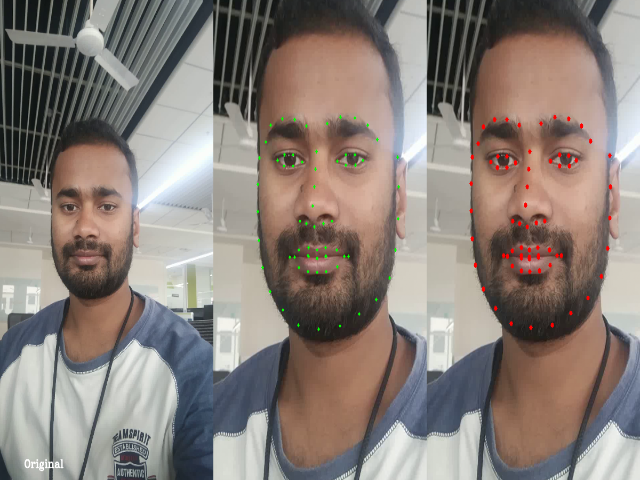

cap is opened


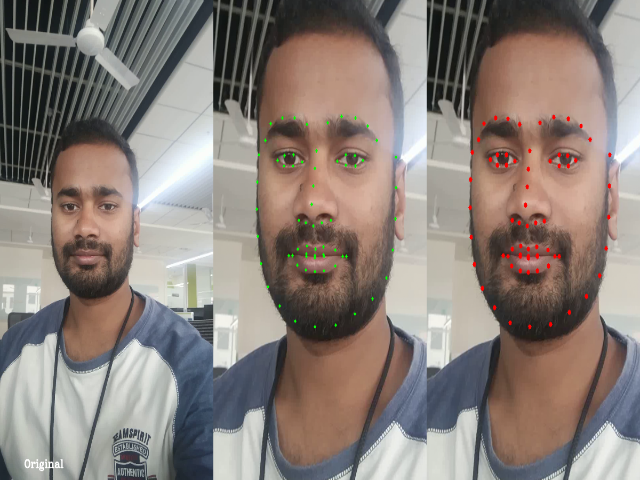

cap is opened


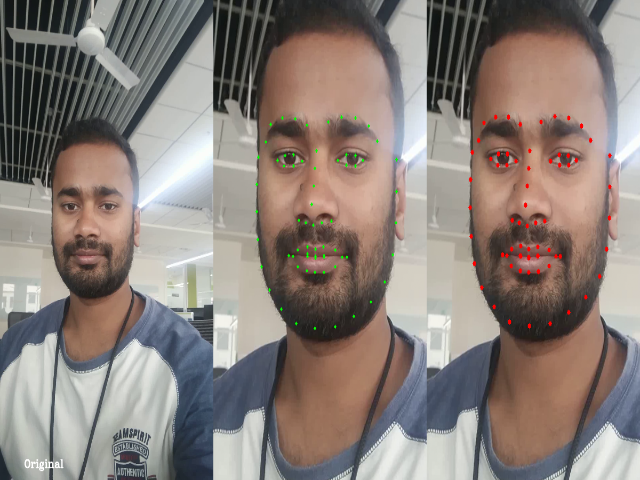

cap is opened


In [0]:
h = 600
w = 400

while(cap.isOpened()):
    print("cap is opened")
    if (count==0):
        t = cv2.getTickCount()

    # Grab a frame
    ret,im = cap.read()
    #print("ret is",ret)
    #print("im is",im)
#     cam = np.copy(im)
    if ret==True:
        points = get_68_pt_detector(frame=im)
        if len(points)==5 or len(points)==68:
            imNorm, points = normalizeImagesAndLandmarks((h, w), np.float32(im)/255.0, points)
            imNorm = np.uint8(imNorm*255)
            kk = drow_circle_points(imNorm, points)
            cam = np.copy(im)
            im = np.copy(imNorm)

    imDlib = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    # COnverting to grayscale
    imGray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    height = im.shape[0]
    IMAGE_RESIZE = float(height)/RESIZE_HEIGHT
    # Resize image for faster face detection
    imSmall = cv2.resize(im, None, fx=1.0/IMAGE_RESIZE, fy=1.0/IMAGE_RESIZE,interpolation = cv2.INTER_LINEAR)
    imSmallDlib = cv2.cvtColor(imSmall, cv2.COLOR_BGR2RGB)
    # Skipping the frames for faster processing
    if (count % SKIP_FRAMES == 0):
        faces = detector(imSmallDlib,0)

    # If no face was detected
    if len(faces)==0:
        print("No face detected")

    # If faces are detected, iterate through each image and detect landmark points
    else:
        for i in range(0,len(faces)):
#       print("face detected")
            # Face detector was found over a smaller image.
            # So, we scale face rectangle to correct size.
            newRect = dlib.rectangle(int(faces[i].left() * IMAGE_RESIZE),
                int(faces[i].top() * IMAGE_RESIZE),
                int(faces[i].right() * IMAGE_RESIZE),
                int(faces[i].bottom() * IMAGE_RESIZE))

            # Detect landmarks in current frame
            landmarks = landmarkDetector(imDlib, newRect).parts()

            # Handling the first frame of video differently,for the first frame copy the current frame points

            if (isFirstFrame==True):
                pointsPrev=[]
                pointsDetectedPrev = []
                [pointsPrev.append((p.x, p.y)) for p in landmarks]
                [pointsDetectedPrev.append((p.x, p.y)) for p in landmarks]

            # If not the first frame, copy points from previous frame.
            else:
                pointsPrev=[]
                pointsDetectedPrev = []
                pointsPrev = points
                pointsDetectedPrev = pointsDetectedCur

            # pointsDetectedCur stores results returned by the facial landmark detector
            # points stores the stabilized landmark points
            points = []
            pointsDetectedCur = []
            [points.append((p.x, p.y)) for p in landmarks]
            [pointsDetectedCur.append((p.x, p.y)) for p in landmarks]

            # Convert to numpy float array
            pointsArr = np.array(points,np.float32)
            pointsPrevArr = np.array(pointsPrev,np.float32)

            # If eye distance is not calculated before
            if eyeDistanceNotCalculated:
                eyeDistance = interEyeDistance(landmarks)
#         print(eyeDistance)
                eyeDistanceNotCalculated = False

            if eyeDistance > 100:
                    dotRadius = 3
            else:
                dotRadius = 2

#       print(eyeDistance)
            sigma = eyeDistance * eyeDistance / 400
            s = 2*int(eyeDistance/4)+1

            #  Set up optical flow params
            lk_params = dict(winSize  = (s, s), maxLevel = 5, criteria = (cv2.TERM_CRITERIA_COUNT | cv2.TERM_CRITERIA_EPS, 20, 0.03))
            # Python Bug. Calculating pyramids and then calculating optical flow results in an error. So directly images are used.
#       ret, imGrayPrev= cv2.buildOpticalFlowPyramid(imGray, (winSize,winSize), maxLevel)
#       print(imDlib.shape,imGray.shape)
            pointsArr,status, err = cv2.calcOpticalFlowPyrLK(im,imDlib,pointsPrevArr,pointsArr,**lk_params)


            # Converting to float
            pointsArrFloat = np.array(pointsArr,np.float32)

            # Converting back to list
            points = pointsArrFloat.tolist()

            # Final landmark points are a weighted average of
            # detected landmarks and tracked landmarks
            for k in range(0,len(landmarks)):
                d = cv2.norm(np.array(pointsDetectedPrev[k]) - np.array(pointsDetectedCur[k]))
                alpha = math.exp(-d*d/sigma)
                points[k] = (1 - alpha) * np.array(pointsDetectedCur[k]) + alpha * np.array(points[k])

            # Drawing over the stabilized landmark points
            if showStabilized is True:
                for p in points:
                    cv2.circle(im,(int(p[0]),int(p[1])),dotRadius, (255,0,0),-1)
            else:
                for p in pointsDetectedCur:
                    cv2.circle(im,(int(p[0]),int(p[1])),dotRadius, (0,0,255),-1)

            isFirstFrame = False
            count = count+1

            # Calculating the fps value
            if ( count == NUM_FRAMES_FOR_FPS):
                t = (cv2.getTickCount()-t)/cv2.getTickFrequency()
                fps = NUM_FRAMES_FOR_FPS/t
                count = 0
                isFirstFrame = True

            # Display the landmarks points
            cv2.putText(im, "{:.1f}-fps Stabilization".format(fps), (50, size[0]-50), cv2.FONT_HERSHEY_COMPLEX, 0.8, (0, 0, 255), 3,cv2.LINE_AA)
            cv2.putText(kk, "Without Stabilization", (50, size[0]-50), cv2.FONT_HERSHEY_COMPLEX, 0.9, (0, 255, 0), 3,cv2.LINE_AA)
            cv2.putText(cam, "   Original", (50, size[0]-50), cv2.FONT_HERSHEY_COMPLEX, 1.5, (255, 255, 255), 3,cv2.LINE_AA)
        #   cv2.imshow(winName, im)
            cam = cv2.resize(cam, (400,600))
#             print(cam.shape)
            im = np.concatenate([cam, kk,im], axis=1)
            final_out = cv2.resize(im, (640, 480))
            #print("final out is",final_out)
            from google.colab.patches import cv2_imshow
            cv2_imshow(final_out)
            out.write(final_out)
        #   frame = cv2.flip(frame,0)
        # write the flipped frame
            # if frame.shape == (480, 640, 3) and final_out.shape == (480, 640, 3):
            # 	out.write(final_out)

            if cv2.waitKey(1) & 0xFF == ord('q'):
                showStabilized = not showStabilized
            imPrev = im
            imGrayPrev = imGray
            # Use spacebar to toggle between Stabilized and Unstabilized version.

            # Stop the program.

    if cv2.waitKey(1) & 0xFF == ord(' '):
        break
            # Getting ready for next frame
            
cap.release()
out.release()
cv2.destroyAllwindows()

In [0]:
# cv2.destroyAllwindows()
# cap.release()

# old version

In [0]:


while(cap.isOpened() and cap1.isOpened()):
  if (count==0):
    t = cv2.getTickCount()

  # Grab a frame
  ret, im = cap.read()
  ret_1, frame = cap1.read()
  imDlib = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
  # COnverting to grayscale
  imGray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
  height = im.shape[0]
  IMAGE_RESIZE = float(height)/RESIZE_HEIGHT
  # Resize image for faster face detection
  imSmall = cv2.resize(im, None, fx=1.0/IMAGE_RESIZE, fy=1.0/IMAGE_RESIZE,interpolation = cv2.INTER_LINEAR)
  imSmallDlib = cv2.cvtColor(imSmall, cv2.COLOR_BGR2RGB)
  # Skipping the frames for faster processing
  if (count % SKIP_FRAMES == 0):
    faces = detector(imSmallDlib,0)

  # If no face was detected
  if len(faces)==0:
    print("No face detected")

  # If faces are detected, iterate through each image and detect landmark points
  else:
    for i in range(0,len(faces)):
#       print("face detected")
      # Face detector was found over a smaller image.
      # So, we scale face rectangle to correct size.
      newRect = dlib.rectangle(int(faces[i].left() * IMAGE_RESIZE),
        int(faces[i].top() * IMAGE_RESIZE),
        int(faces[i].right() * IMAGE_RESIZE),
        int(faces[i].bottom() * IMAGE_RESIZE))
      
      # Detect landmarks in current frame
      landmarks = landmarkDetector(imDlib, newRect).parts()
      
      # Handling the first frame of video differently,for the first frame copy the current frame points
      
      if (isFirstFrame==True):
        pointsPrev=[]
        pointsDetectedPrev = []
        [pointsPrev.append((p.x, p.y)) for p in landmarks]
        [pointsDetectedPrev.append((p.x, p.y)) for p in landmarks]

      # If not the first frame, copy points from previous frame.
      else:
        pointsPrev=[]
        pointsDetectedPrev = []
        pointsPrev = points
        pointsDetectedPrev = pointsDetectedCur

      # pointsDetectedCur stores results returned by the facial landmark detector
      # points stores the stabilized landmark points
      points = []
      pointsDetectedCur = []
      [points.append((p.x, p.y)) for p in landmarks]
      [pointsDetectedCur.append((p.x, p.y)) for p in landmarks]

      # Convert to numpy float array
      pointsArr = np.array(points,np.float32)
      pointsPrevArr = np.array(pointsPrev,np.float32)

      # If eye distance is not calculated before
      if eyeDistanceNotCalculated:
        eyeDistance = interEyeDistance(landmarks)
#         print(eyeDistance)
        eyeDistanceNotCalculated = False

      if eyeDistance > 100:
          dotRadius = 3
      else:
        dotRadius = 2

#       print(eyeDistance)
      sigma = eyeDistance * eyeDistance / 400
      s = 2*int(eyeDistance/4)+1

      #  Set up optical flow params
      lk_params = dict(winSize  = (s, s), maxLevel = 5, criteria = (cv2.TERM_CRITERIA_COUNT | cv2.TERM_CRITERIA_EPS, 20, 0.03))
      # Python Bug. Calculating pyramids and then calculating optical flow results in an error. So directly images are used.
#       ret, imGrayPrev= cv2.buildOpticalFlowPyramid(imGray, (winSize,winSize), maxLevel)
#       print(imDlib.shape,imGray.shape)
      pointsArr,status, err = cv2.calcOpticalFlowPyrLK(im,imDlib,pointsPrevArr,pointsArr,**lk_params)
      

      # Converting to float
      pointsArrFloat = np.array(pointsArr,np.float32)

      # Converting back to list
      points = pointsArrFloat.tolist()

      # Final landmark points are a weighted average of
      # detected landmarks and tracked landmarks
      for k in range(0,len(landmarks)):
        d = cv2.norm(np.array(pointsDetectedPrev[k]) - np.array(pointsDetectedCur[k]))
        alpha = math.exp(-d*d/sigma)
        points[k] = (1 - alpha) * np.array(pointsDetectedCur[k]) + alpha * np.array(points[k])

      # Drawing over the stabilized landmark points
      if showStabilized is True:
        for p in points:
          cv2.circle(im,(int(p[0]),int(p[1])),dotRadius, (255,0,0),-1)
      else:
        for p in pointsDetectedCur:
          cv2.circle(im,(int(p[0]),int(p[1])),dotRadius, (0,0,255),-1)

      isFirstFrame = False
      count = count+1

      # Calculating the fps value
      if ( count == NUM_FRAMES_FOR_FPS):
        t = (cv2.getTickCount()-t)/cv2.getTickFrequency()
        fps = NUM_FRAMES_FOR_FPS/t
        count = 0
        isFirstFrame = True

      # Display the landmarks points
      cv2.putText(im, "{:.1f}-fps".format(fps), (50, size[0]-50), cv2.FONT_HERSHEY_COMPLEX, 1.5, (0, 0, 255), 3,cv2.LINE_AA)
    #   cv2.imshow(winName, im)
      if ret_1==True:
        points = get_68_pt_detector(frame=frame)
        if len(points)==5 or len(points)==68:
            imNorm5, img_with_5_point = img_and_pont_circle_norm(points = points)

      frame = cv2.resize(frame, (214,480))
      not_stab_img = cv.resize(imNorm5, (214,480))
      im = cv2.resize(im, (214, 480))
      final_out = np.concatenate([frame, not_stab_img, im], axis=1)
      final_out = cv2.resize(im, (640, 480))

      out.write(final_out)
    #   frame = cv2.flip(frame,0)
      if cv2.waitKey(1) & 0xFF == ord('q'):
        showStabilized = not showStabilized

      key = cv2.waitKey(25) & 0xFF

      # Use spacebar to toggle between Stabilized and Unstabilized version.
      if key==32:
        showStabilized = not showStabilized

      # Stop the program.
      if key==27:
        print("ok")
        sys.exit()
      # Getting ready for next frame
      imPrev = im
      imGrayPrev = imGray

cv2.destroyAllwindows()
cap.release()